### Install requirements

In [ ]:
%%capture
%pip install -r requirements.txt

### Cell bellow increases output limit of jupyter notebook

In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

### Imports

In [2]:
# print all outputs in shell, not just the last print that was called in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# for dataset splitting. Not too important here as we are not building a predictive model
from sklearn.model_selection import train_test_split

# data handling 
import pandas as pd
# plotting 
# from matplotlib import rc
from matplotlib import style 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import cm
from matplotlib.ticker import MaxNLocator
style.use('seaborn-bright')
plt.rcParams['font.family'] = "serif"

# array handling 
import numpy as np
# precrocessing 
from sklearn.cluster import KMeans
from scipy.interpolate import UnivariateSpline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# dimensionality reduction
from sklearn.decomposition import PCA
# splitting ranking-based datasets
from sklearn.model_selection import GroupShuffleSplit
# models 
from xgboost import XGBRegressor, XGBClassifier, XGBRanker
# metrics for regression, classification and ranking top_k_accuracy
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc 
from sklearn.metrics import ndcg_score as ndcg

# Optimization module; Bayesian Optimization. Often applied in Reinforcement learning. 
# Although it is not the most commonly used for supervised learning.
# AWS, the cloud provider, has pretty much set in stone 
# that using xtreme gradient boosting for hyperparameter optimization 
# #is actually one of the best approaches to take. It is how they implement their hyperparameter 
# optmization on their end-to-end ML platform; Sagemaker. 
from bayes_opt import BayesianOptimization

A small note before reviewing the style of my code:
<br><br>
There is lots of refactoring to do.I would never dare attempt to place such messy code into production. Python lends itself well to both functional and object orientated paradigms in programming, none of which I have efficiently used here. I am also not using the typing of input parameters, but am aware of the benefit for readability. But this is more a concern of my software development practices, and not by knowledge of linear algebra, multi-variate optimization and statistics and probability; the bedrock of machine learning and data science. Nevertheless, I would like to make you aware that I am aware of the messy and inefficient approach; we can always make it better. 
<br><br>
We have a baby dataset here, so using just the cores available via the CPU still allows reasonable processing time. This would not be the case for large scale training. A GPU would provide accelerated training. Please see the details here for how to  [train using the XGBoost library on a GPU](https://xgboost.readthedocs.io/en/stable/gpu/index.html)
<br><br>
I think for explainability you may find the [CatBoost](https://catboost.ai/) library of interest too, feel free to review it. I have not applied it here as the [cardinality](https://en.wikipedia.org/wiki/Cardinality_(data_modeling)) of the features is low.
<br><br>
**Note** 
<br>
Running these cells will produce plots that are saved to your local file system in the sub directory `figs/`

### Retrieving data

In [3]:
FILE_URL = "https://github.com/fivethirtyeight/data/blob/master/candy-power-ranking/candy-data.csv"
TRG_COL = "winpercent"

def get_data(file_url=FILE_URL, drop=True, scale_target=True, print=False , scaler=StandardScaler):
    """Reads data from embedding table
        param: 
            drop: drop_column corresponding to producer
            file_url: the url of the csv file 
            scale_target: bool deciding whether to scale the target variable; we are not doing any deep learning, where we assume we have remove the bias from the dataset, so scaling isn't important
            scaler: scaling method used, instance of SKLearn 
        """
    trg_col = "winpercent"
    df = pd.read_html(file_url)[0]
    df.drop(inplace=True, columns=['Unnamed: 0'])
    if drop:
        if print:
            print(f"flag drop={drop}:\nDropping candy producer")
            print("*"*20)
        df.drop(inplace=True, columns=['competitorname'])
    if scale_target:
        if print:
            print(f"flag scale_target={scale_target}:\nUsing min max scaler on targets")
            print("*"*20)
        target_scaler = scaler()
        df[trg_col]= target_scaler.fit_transform(df[[trg_col]])
    return df 

df = get_data(scale_target=False, drop=False)
df.head(5)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465


### Meta data
| Header | Description |
|--------|-------------| 
|chocolate | Does it contain chocolate?|
|fruity | Is it fruit flavored?|
|caramel | Is there caramel in the candy?|
|peanutalmondy | Does it contain peanuts, peanut butter or almonds?|
|nougat | Does it contain nougat?|
|crispedricewafer | Does it contain crisped rice, wafers, or a cookie component?|
|hard | Is it a hard candy?|
|bar | Is it a candy bar?|
|pluribus | Is it one of many candies in a bag or box?|
|sugarpercent | The percentile of sugar it falls under within the data set.|
|pricepercent | The unit price percentile compared to the rest of the set.|
|winpercent | The overall win percentage according to 269,000 matchups.|

### data preparation 

In [ ]:
# def dataset_splitting(df, with_test=False, with_val=True, print=False, trg_col="winpercent"):
#   split_y_x = lambda df: (df[[trg_col]], df.drop(columns=[trg_col]))
#   if with_test and with_val:
#     df_split_further, df_eval = train_test_split(df, test_size=0.10)
#     df_train, df_val = train_test_split(df_split_further, test_size=0.20)
#     if print:
#       print(f'Eval set ========: {df_eval.shape[0]*100/df.shape[0]:.2f}%')
#       print(f'Val set =========: {df_val.shape[0]*100/df.shape[0]:.2f}%')
#       print(f'Train set =======: {df_train.shape[0]*100/df.shape[0]:.2f}%')  
#     Yt, Xt = split_y_x(df_train) 
#     Yv, Xv = split_y_x(df_val)
#     Ye, Xe = split_y_x(df_eval)
#     return Xt, Yt, Xv, Yv, Xe, Ye
#   elif with_test and not with_val:
#     df_train, df_eval = train_test_split(df, test_size=0.10)
#     if print:
#       print(f'Eval set ========: {df_eval.shape[0]*100/df.shape[0]:.2f}%')
#       print(f'Train set =======: {df_train.shape[0]*100/df.shape[0]:.2f}%')
#     Yt, Xt = split_y_x(df_train) 
#     Ye, Xe = split_y_x(df_eval)
#     return Xt, Yt, Xe, Ye
#   elif not with_test and not with_val:
#     Y, X = split_y_x(df)
#     return X,Y

### Exploratory analysis
Target distribution insight, uni and multi-variate analysis

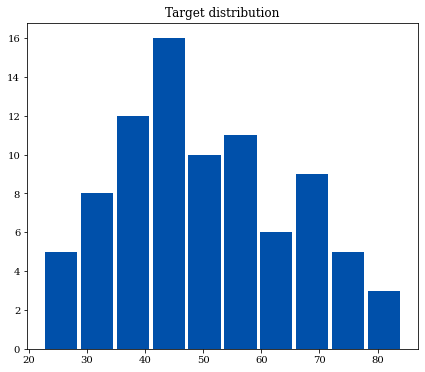

In [4]:
def plot_target_distribution():
    """Target distribution"""
    fig = plt.figure(figsize=(7,6))
    ax1 = fig.add_subplot(111)
    y = get_data(scale_target=False)[TRG_COL]
    counts, bins = np.histogram(y)
    ax1.set_title("Target distribution")
    ax1.hist(bins[:-1],bins, weights=counts, rwidth=0.90, color='#0050aa')
    plt.savefig(f"figs/target_hist.png", dpi=400, bbox_inches="tight")

plot_target_distribution()

##### exploring binary variable distribution via boxplots

<AxesSubplot:xlabel='chocolate', ylabel='winpercent'>

<AxesSubplot:xlabel='chocolate', ylabel='winpercent'>

Text(0.5, 1.0, 'Distribution of win percentage\nby chocolate')

<AxesSubplot:xlabel='fruity', ylabel='winpercent'>

<AxesSubplot:xlabel='fruity', ylabel='winpercent'>

Text(0.5, 1.0, 'Distribution of win percentage\nby fruity')

<AxesSubplot:xlabel='caramel', ylabel='winpercent'>

<AxesSubplot:xlabel='caramel', ylabel='winpercent'>

Text(0.5, 1.0, 'Distribution of win percentage\nby caramel')

<AxesSubplot:xlabel='peanutyalmondy', ylabel='winpercent'>

<AxesSubplot:xlabel='peanutyalmondy', ylabel='winpercent'>

Text(0.5, 1.0, 'Distribution of win percentage\nby peanutyalmondy')

<AxesSubplot:xlabel='nougat', ylabel='winpercent'>

<AxesSubplot:xlabel='nougat', ylabel='winpercent'>

Text(0.5, 1.0, 'Distribution of win percentage\nby nougat')

<AxesSubplot:xlabel='crispedricewafer', ylabel='winpercent'>

<AxesSubplot:xlabel='crispedricewafer', ylabel='winpercent'>

Text(0.5, 1.0, 'Distribution of win percentage\nby crispedricewafer')

<AxesSubplot:xlabel='hard', ylabel='winpercent'>

<AxesSubplot:xlabel='hard', ylabel='winpercent'>

Text(0.5, 1.0, 'Distribution of win percentage\nby hard')

<AxesSubplot:xlabel='bar', ylabel='winpercent'>

<AxesSubplot:xlabel='bar', ylabel='winpercent'>

Text(0.5, 1.0, 'Distribution of win percentage\nby bar')

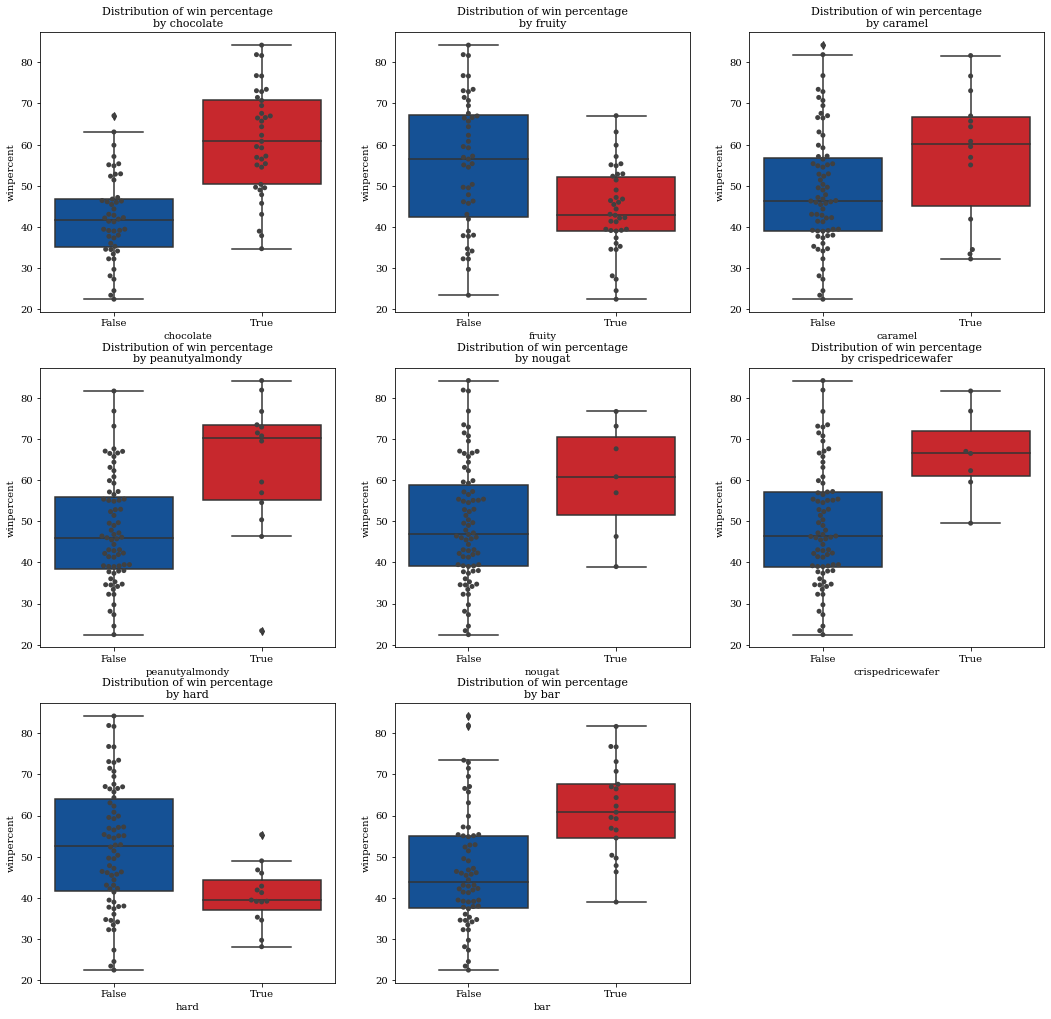

In [5]:
# lidl colour pallete
colors = ["#0050aa", "#e20d14"]
palette_style = sns.set_palette(sns.color_palette(colors))


df = get_data(scale_target=False)
binary_feats = [feat for feat in list(df.columns) if feat not in ["winpercent","pricepercent","sugarpercent"]]
df[binary_feats] = df[binary_feats].astype(bool)
fig, axs = plt.subplots(3,3, figsize=(18,16))
plt.subplots_adjust(top = 0.95)
fig.delaxes(axs[2,2])

for feat,ax in zip(binary_feats, fig.axes):
    sns.boxplot(x=feat,y=TRG_COL,data=df,ax=ax,palette=palette_style)
    sns.swarmplot(x=feat, y=TRG_COL, data=df,ax=ax, color=".25")    
    # Format plot title
    plot_title_str = f'Distribution of win percentage\nby {feat}'
    ax.set_title(plot_title_str,fontsize=11)

plt.savefig("figs/box-plots.png", dpi=400, bbox_inches="tight")

##### Correlation plot of variables

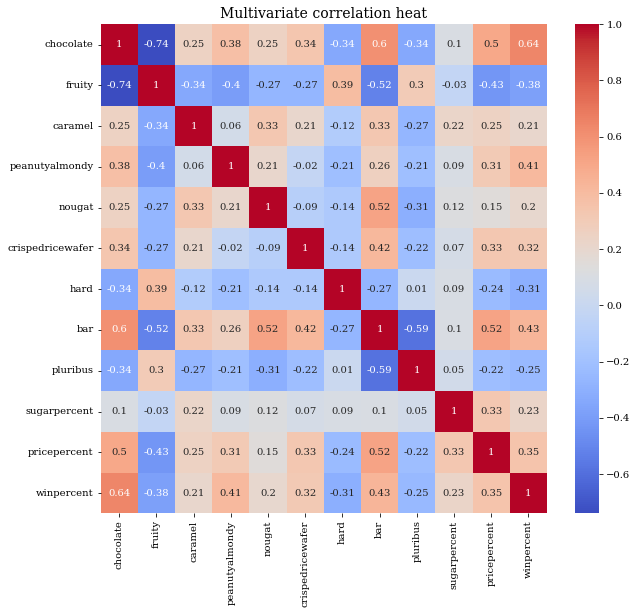

In [6]:
def plot_correlation(df):    
    corr = df.corr().round(decimals=2)
    # Hide upper right diagonal
    mask = np.zeros_like(corr)
    fig = plt.figure(figsize=(10,9))
    sns.heatmap(data=corr, mask=mask, annot=True, cmap='coolwarm')
    plt.title("Multivariate correlation heat", fontsize=14)
    plt.savefig("figs/correlation.png", dpi=400, bbox_inches="tight")

plot_correlation(df)

### Feature importance plotting 
The function bellow will plot the feature importance returned by our ensemble learning approach. The weak underlying learners making up the ensemble, *decision trees*, gift us the hierarchical feature importance.

This is a helper function used later on

In [7]:
def plot_feature_importance(feature_importances,feature_names, case="", save=True):
    '''Plotting feature importance
        params:
            feature_importances: a list of numpy arrays containing the values of feature importances, will be stack and averaged over 
            feature_names: the feature names in order of the pandas dataframe column, only containing the features
            case: a str to help 
        '''    
    feat_importance = sorted(list(zip(np.vstack(feature_importances).mean(axis=0),feature_names)),key= lambda y: y[0], reverse=False)
    feats = [feat.capitalize() for (_,feat) in feat_importance]
    feats = [x.replace("percent", " percent") for x in feats]
    feats = [x.replace("almondy", " and almondy") for x in feats]
    feats = [x.replace("ricewafer", " rice wafer") for x in feats]
    print(feats)
    val = [x for (x,_) in feat_importance]

    fig = plt.figure(figsize=(5,10))
    ax = plt.subplot()
    y_pos = np.arange(len(feats))
    ax.barh(y=feats,width=val, align='center', color='#0050aa')
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_title(f'Feature importance:\n{case}', fontsize=16)
    ax.set_ylabel('Features', fontsize=14)
    if save:
        plt.savefig(fname=f"figs/{case}_xgboost.png", dpi=400, bbox_inches="tight")


### Architecture Extreme gradient boosting: Feature importance analysis with hyperparameter optimization
To start with, we will treat the data as if it were a supervised regression task. That is, the ensemble of decision trees is made to minimise the the squared error between the winning precentage of the candy and the predicted value of our model
<br><br>
The below class is used to perform the repeated fitting of our total ensemble on the dataset, and stores the obtained feature importance array, from each fit, in an list, which we later average over.
<br><br>
We use a stastical optimization technique called [Bayesian optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) to guide the search of the hyperparameter space with each fit. Was messing around with [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing#:~:text=Simulated%20annealing%20(SA)%20is%20a,space%20for%20an%20optimization%20problem.) but decided just to stick to Bayesian optimization.  

#### root parameters for xgboosters
Both the search space ( `PARAM_DOMAIN`  ) and fixed model parameters (`FIXED_PARAMS` ) are specified below and passed to the the trainer class.

In [8]:

PARAM_DOMAIN = { 
                  'gamma'                    : (0.1, 20),  # regularisation param
                  'colsample_bytree'         : (0.05, 1),  # exploring subsample of dataset probability of each tree 
                  'subsample'                : (0.4, 1),   # havent got a big sample, force to use majority of dataset
                  'max_depth'                : (7, 16),    # make sure the model stays in the range of using  11 features
                  'reg_alpha'                : (0.1, 20),  # regularisation param
                  'reg_lambda'               : (0.1, 20),  # regualarisation param 
                  'min_child_weight'         : (0.0001, 50) # regularisation param
                  }
FIXED_PARAMS = {
                  'booster'              : 'dart',     # base learner type; a gradient boost tree with dropout to help regularise; see https://xgboost.readthedocs.io/en/stable/tutorials/dart.html
                  'learning_rate'        : 0.05,       # learning rate, how much each tree should contribute 
                  'sample_type'          : 'uniform',  # how to sample across ds
      
                }

#### base trainer class

In [10]:
class XGBooster:
    
    BAYES_OPT_RAND_SEED = 3
    TRAIN_TEST_SPLIT_RAND_SEED = 39

    def __init__(self,df, trg_col, case, metric, min_or_max, booster, args_to_add, fixed_params, param_domain=PARAM_DOMAIN):
        self.df = df 
        self.trg_col = trg_col
        self.case = case 
        self.min_or_max = min_or_max
        self.metric = metric
        self.booster = booster
        self.fixed_params = fixed_params

        self.fixed_params = {**fixed_params, **args_to_add}

        self.param_domain = param_domain

        self.power = 0.5 if "squarederror" in self.fixed_params["objective"] else 1.0
        self.is_ranking = True if isinstance(XGBRanker(),booster) else False
        print("ranking?", self.is_ranking)
        self.feature_names = [feats for feats in df.columns if feats != trg_col]
        self.feature_importances = []
        # if not self.is_ranking


    
    def split_y_x(self,df):
        return (df[[self.trg_col]], df.drop(columns=[self.trg_col]))


    def bayesian_ensemble_optimization(self): 
        func = self.hyper_tuning_xgb
        '''Function performs Bayesian optmization on 'black box' input function over parameter  domain '''
        bayesian_optimizer = BayesianOptimization(f = func,
                                                    pbounds = self.param_domain,
                                                    random_state = XGBooster.BAYES_OPT_RAND_SEED)
        bayesian_optimizer.maximize(init_points= 20,        # How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
                                    n_iter = 10,            # How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
                                    xi = 0.1,               # Param space Exploitation-exploration trade-off parameter 
                                    acq = 'ucb',            # Param space exploration strategy; upper confidence bound
                                    kappa=2.576,            # tunable parameter kappa of GP Upper Confidence Bound, to balance exploitation against exploration, increasing kappa will make the optimized hyperparameters pursuing exploration.
                                    kappa_decay = 1) 
        return bayesian_optimizer
        
    

    def hyper_tuning_xgb(self,subsample, max_depth, gamma, reg_alpha, reg_lambda, colsample_bytree,min_child_weight):
        ''' Function to be optimized
            params:
                subsample: these are the hyper parameters I described above
                max_depth: maximum amount of sequential partitions made by the tree on the data
                gamma: note actually used
                reg_alpha: reg
                reg_lambda:  reeg
                colsample_bytree:
                min_child_weight: using this instead of gamma, reg. See https://stats.stackexchange.com/questions/418687/gamma-parameter-in-xgboost
                '''
        params = self.fixed_params
        # params to optimize
        params['subsample']                  = max(min(subsample, 1), 0)  
        params['colsample_bytree']           = max(min(colsample_bytree, 1), 0)
        params['max_depth']                  = int(round(max_depth))
        params['reg_alpha']                  = reg_alpha
        params['reg_lambda']                 = reg_lambda
        params['min_child_weight']           = min_child_weight
        
        if not self.is_ranking:
            dft,dfe =  train_test_split(self.df, test_size=0.20, random_state= XGBooster.TRAIN_TEST_SPLIT_RAND_SEED)
            yt,xt = self.split_y_x(dft)
            ye,xe = self.split_y_x(dfe)
            booster = self.booster
            booster_fitted = booster(**params).fit(X = xt, y =yt)
            # using as place holder
            self.feature_importances.append(booster_fitted.feature_importances_)
            return self.min_or_max*self.metric(ye, booster_fitted.predict(xe))**(self.power) 


        if self.is_ranking:
            df_ranking = self.df 
            gss = GroupShuffleSplit(test_size=.25, n_splits=1).split(df_ranking, groups=df_ranking["cluster_id"])
            train_ids, test_ids = next(gss)
            df_train = df_ranking.iloc[train_ids]

            xt = df_train.loc[:, ~df_train.columns.isin(["cluster_id", self.trg_col])]
            yt = df_train.loc[:, df_train.columns.isin([self.trg_col])]
    
            groups = df_train.groupby('cluster_id').size().to_frame('size')['size'].to_numpy()
            df_test = df_ranking.iloc[test_ids]
    
            xe = df_test.loc[:, ~df_test.columns.isin([self.trg_col])]    
            ye = df_test.loc[:, df_test.columns.isin([self.trg_col])]

            booster = self.booster
            booster_fitted = booster(**params).fit(xt, yt, group=groups, verbose=True)
            def predict(model, df):
                return model.predict(df.loc[:, ~df.columns.isin(["cluster_id"])])

            predictions = xe.groupby("cluster_id").apply(lambda x: predict(booster_fitted, x))
            score = np.asarray([predictions.array[0]])
            rel = np.asarray([ye[self.trg_col].values])
            return self.min_or_max*self.metric(rel, score)**(self.power) 


        
    def optimal_gb(self):
        '''Method inits bayesian ensemble optimization routine and returns best hyper parameter set.
           The feature importances (there values through the hyperparameter fitting process) are collected during the optimization routine and hence
           we return the instance of the class (self) alone with the optimal fitted booster. The instance object is passed  to the plotting 
           function that averages across the feature importances values. 
           '''

        optimizer_results = self.bayesian_ensemble_optimization()
        optimal_params = optimizer_results.max['params']
        optimal_params['max_depth'] = int(optimal_params['max_depth'])
        optimal_params.update(self.fixed_params)

        if not self.is_ranking:
            df = self.df 
            Y_data, X_data = self.split_y_x(df)
            booster = self.booster
            model_booster =  booster(**optimal_params).fit(X = X_data, y =Y_data)
            return self, model_booster

        if self.is_ranking:

            df_ranking = self.df 
            gss = GroupShuffleSplit(test_size=.25, n_splits=1, random_state = 22).split(df_ranking, groups=df_ranking["cluster_id"])
            train_ids, _ = next(gss)
            df_train = df_ranking.iloc[train_ids]
            xt = df_train.loc[:, ~df_train.columns.isin(["cluster_id",self.trg_col])]
            yt = df_train.loc[:, df_train.columns.isin([self.trg_col])]
    
    
            groups = df_train.groupby('cluster_id').size().to_frame('size')['size'].to_numpy()
            booster = self.booster
            model_booster =  booster(**optimal_params).fit(X = xt, y =yt, group=groups)
            return self, model_booster 


### Regression task specification and fitting

ranking? False
|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.9436   |  0.5733   |  14.19    |  9.618    |  25.54    |  17.87    |  17.94    |  0.4754   |
|  2        | -0.9183   |  0.2469   |  1.124    |  10.97    |  1.494    |  9.191    |  13.02    |  0.5671   |
|  3        | -1.031    |  0.6924   |  11.86    |  7.216    |  27.94    |  5.259    |  8.361    |  0.5701   |
|  4        | -0.9569   |  0.7085   |  8.865    |  8.412    |  27.23    |  15.63    |  6.197    |  0.5332   |
|  5        | -0.9516   |  0.4186   |  18.73    |  15.78    |  33.62    |  18.07    |  16.93    |  0.6268   |
|  6        | -0.9718   |  0.1376   |  13.1     |  12.02    |  18.08    |  4.579    |  8.19     |  0.6814   |
|  7        | -0.9427   |  0.3058   |  5.907    |  11.12    |  43.03    |  11.77    |  5.741    |  0.5668

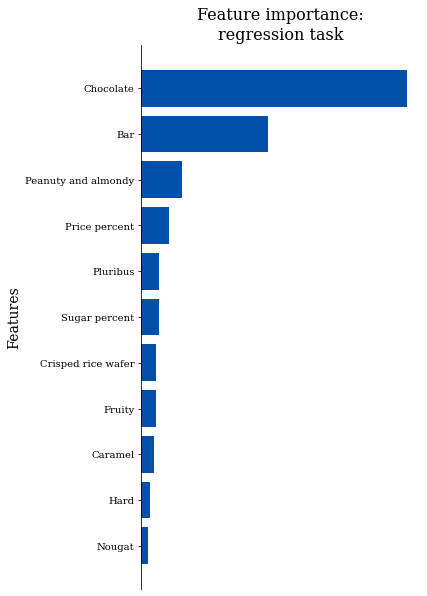

In [11]:
df = get_data()

trg_col = "winpercent"
case = "regression task"
add_args = {"objective":"reg:squarederror"}
min_or_max = -1.0
metric = mse
booster = XGBRegressor


trainer = XGBooster(df, trg_col, case, metric, min_or_max, booster, add_args, FIXED_PARAMS)
opt_trainer, optimal_model = trainer.optimal_gb()


plot_feature_importance(feature_importances=opt_trainer.feature_importances,
                        feature_names=opt_trainer.feature_names,
                        case=case)

### Unsupervised clustering and cluster classification
Will use the associated cluster groups to rank within. The ranker will also be based on the  XGBoost model family. This will provide us with the suggestions of which candies to add to our collection.  But first, lets do the clustering.
##### Heuristic for choosing the number of cluster. 
A priroi, it is not none what the best **number** of clusters is, to cluster the dataset into. Need to implement the heuristic [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) ) to choose this number, this is done within the class below. I use splines from the scipy library to approximate a continuous curve of the discrete elbow plot. Then finding the $2^{nd}$ (or $3^{rd}$ give it a try) derivative of the fitted splines to find the kink (or elbow) at which the trade-off between centroid separation and in cluster variance is not considered beneficial. 
<br><br>
**NOTE** we dont use the target column during the clustering. We want the clustering to be based on the similiarty between the candies themselves, not the reported preferences.

The 1th principle component explains 50% of the data
The 2th principle component explains 18% of the data


,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,cluster_id,winpercent,competitorname
0,1,0,1,0,0,1,0,1,0,0.732,0.860,3,66.971725,100 Grand
1,1,0,0,0,1,0,0,1,0,0.604,0.511,3,67.602936,3 Musketeers
2,0,0,0,0,0,0,0,0,0,0.011,0.116,0,32.261086,One dime
3,0,0,0,0,0,0,0,0,0,0.011,0.511,0,46.116505,One quarter
4,0,1,0,0,0,0,0,0,0,0.906,0.511,0,52.341465,Air Heads


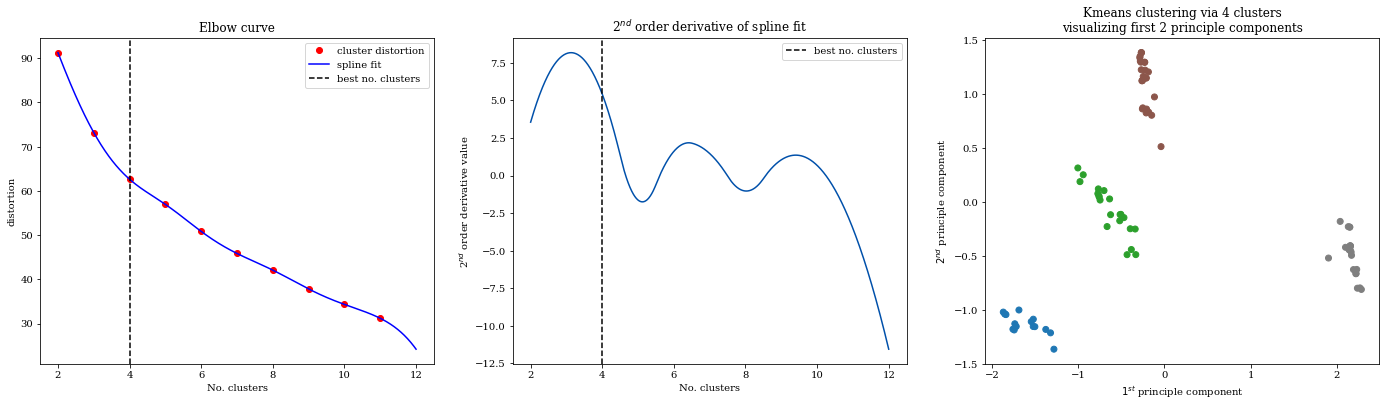

In [12]:

class ClusterGenerator:
    # make sure that the degree of the polynomial used to fit the spline is two degrees larger than the derivative you want to 
    # use to find the kink in the elbow method. Otherwise the plotted nth derivative wont be smooth. 
    DERIVATIVE_NUM = 2
    POLYNOMIAL_DEGREE = 4
    KMEANS_CLUSTER_RAND_SEED =18
    # Was considering the third derivative hence the comment to find the kink in the elbow curve. Strangely, no matter the random seed, 
    # if you use the third derivative you will generally cluster into 6 or more clusters. Moreover, the data can clearly be seen to lie 
    # on a parabolic manifold, a non-linear manifold that PCA (a linear dim reduction technique) cannot approximiate 
    # to reproduce: 
    # DERIVATIVE_NUM = 3
    # POLYNOMIAL_DEGREE = 5
    # KMEANS_CLUSTER_RAND_SEED =1898
    # Note that the title of the spline fit needs to have the superscript of the derivative change from 'nd' to 'rd'
    def __init__(self, df, trg_col, aux_col):

        self.df = df
        self.df_trg_aux = df[[trg_col,aux_col]]
        self.df.drop(columns=[trg_col, aux_col],inplace=True)

        self.opt_num_cluster = None 
    

    def get_distortions(self, no_cluster_range):
        ''' Using elbow method to calculate best number of cluster using distortion method
            params:
                X: dataframe to be clustered
                no_cluster_range: list of min and max cluster numbers'''
        distorsions = []
        for k in range(*no_cluster_range):
            kmeans = KMeans(n_clusters=k,random_state=ClusterGenerator.KMEANS_CLUSTER_RAND_SEED)
            kmeans.fit(self.df)
            distorsions.append(kmeans.inertia_)
        return distorsions

    def get_best_no_cluster(self,no_cluster_range, distortion):
        '''interpolating distortion value for each number of clusters, 
            plotting interpolated values and finding maximum second 
            order derivative to find best cluster number
            params:
                no_cluster_range: list of min and max cluster numbers
                distortion: distortion value list for number of clusters considered'''
        y_spl = UnivariateSpline(range(*no_cluster_range), distortion, s=0,k=ClusterGenerator.POLYNOMIAL_DEGREE)
        fig,axs = plt.subplots(1,3,figsize=(24,6))

        axs[0].set_title("Elbow curve")
        axs[0].plot(range(*no_cluster_range), distortion, 'ro', label="cluster distortion")
        x_range = np.linspace(*no_cluster_range,1000)

        
        axs[0].plot(x_range,y_spl(x_range),'b', label="spline fit")
        axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

        axs[0].set_ylabel("distortion")
        axs[0].set_xlabel("No. clusters")
        axs[0].legend()
        y_spl_2d = y_spl.derivative(n=ClusterGenerator.DERIVATIVE_NUM)

        axs[1].set_title( str(ClusterGenerator.DERIVATIVE_NUM)+r"$^{nd}$ order derivative of spline fit")
        axs[1].plot(x_range, y_spl_2d(x_range))
        axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

        axs[1].set_ylabel(str(ClusterGenerator.DERIVATIVE_NUM)+r"$^{nd}$ order derivative value")
        axs[1].set_xlabel("No. clusters")

        x_range = np.linspace(min(no_cluster_range)+1, max(no_cluster_range)-2,1000)
        best_number_of_cluster = np.ceil(sorted(zip(x_range,y_spl_2d(x_range)), key=lambda x: x[1], reverse=True)[0][0])

        for ax in axs[:-1]:
            ax.axvline(x=best_number_of_cluster, color='k', linestyle='--', label="best no. clusters")
        axs[0].legend()
        axs[1].legend()
        return int(best_number_of_cluster),axs[2]



    def plot_clustering(self,df_w_cluster_ids, opt_cluster_no, ax):
        '''Plotting cluster dataset using optimal cluster number
            params:
                df_w_cluster_ids: df with associated cluster ids
                opt_cluster_no: optimal cluster number, used for coloring scatter plot'''
        pca = PCA(n_components=2)
        [print(f"The {i+1}th principle component explains {var*100:.0f}% of the data") for i,var in enumerate(pca.fit(df_w_cluster_ids).explained_variance_ratio_)]
        cm = plt.get_cmap('tab10')
        colours = dict(zip(range(opt_cluster_no),[cm(i/opt_cluster_no) for i in range(opt_cluster_no)] ))
        
        kmeans  = KMeans(n_clusters=opt_cluster_no,random_state=ClusterGenerator.KMEANS_CLUSTER_RAND_SEED).fit(self.df.values)
        x = pca.fit_transform(kmeans.fit_transform(df_w_cluster_ids))

        ax.set_title(f"Kmeans clustering via {opt_cluster_no} clusters\nvisualizing first 2 principle components")
        ax.set_ylabel(r"$2^{nd}$ principle component")
        ax.set_xlabel(r"$1^{st}$ principle component")
        ax.scatter(x[:,0], x[:,1], c=df_w_cluster_ids['cluster_id'].map(colours) )
        plt.savefig("figs/kmeans-cluster-choice.png", dpi=400, bbox_inches="tight")


    def get_df_and_plot(self, cluster_range):

        distortion = self.get_distortions(cluster_range)
        opt_no_clusters, ax = self.get_best_no_cluster(cluster_range, distortion)
        kmeans  = KMeans(n_clusters=opt_no_clusters,random_state=ClusterGenerator.KMEANS_CLUSTER_RAND_SEED).fit(self.df.values)
        df_clust  = self.df
        # associated cluster ids to data
        df_clust['cluster_id'] = kmeans.labels_
        self.plot_clustering(df_clust, opt_cluster_no=opt_no_clusters, ax=ax)
        # bring back the target and competitior col
        df_clust = pd.concat([df_clust, self.df_trg_aux],axis=1)
        return df_clust

    
    

cluster_range = [2,12]
df = get_data(scale_target=False, drop=False)
trg_col = "winpercent"
aux_col = "competitorname"

cluster_plotter = ClusterGenerator(df, trg_col,aux_col)
df_clust = cluster_plotter.get_df_and_plot(cluster_range)

df_clust.head()

#### Multi-label classification fitting and feature importance plotting
Note that the object cell needs to be run such that the number of clusters can be injected into the additional arguments needed by the trainer class.

ranking? False
|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.05882  |  0.5733   |  14.19    |  9.618    |  25.54    |  17.87    |  17.94    |  0.4754   |
|  2        |  0.3529   |  0.2469   |  1.124    |  10.97    |  1.494    |  9.191    |  13.02    |  0.5671   |
|  3        |  0.05882  |  0.6924   |  11.86    |  7.216    |  27.94    |  5.259    |  8.361    |  0.5701   |
|  4        |  0.05882  |  0.7085   |  8.865    |  8.412    |  27.23    |  15.63    |  6.197    |  0.5332   |
|  5        |  0.05882  |  0.4186   |  18.73    |  15.78    |  33.62    |  18.07    |  16.93    |  0.6268   |
|  6        |  0.3529   |  0.1376   |  13.1     |  12.02    |  18.08    |  4.579    |  8.19     |  0.6814   |
|  7        |  0.05882  |  0.3058   |  5.907    |  11.12    |  43.03    |  11.77    |  5.741    |  0.5668

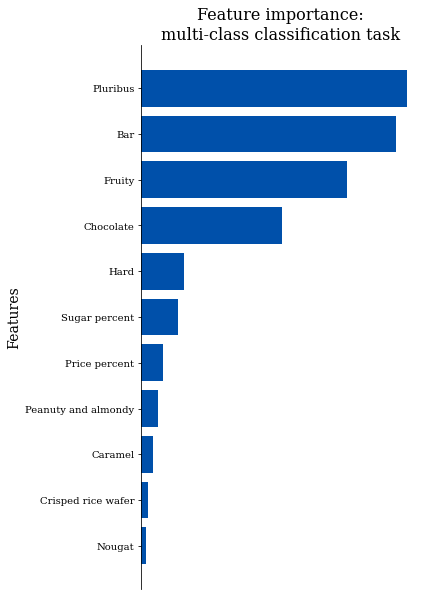

In [13]:

trg_col = "cluster_id"
case = "multi-class classification task"
df_wo_trg = df_clust.drop(columns=['winpercent','competitorname'])

add_args_for_classification =  {
    'objective' : 'multi:softmax',
    'num_class' : int(len(set(df_wo_trg.cluster_id)))
    }


FIXED_PARAMS = {
                  'booster'              : 'dart',
                  'learning_rate'        : 0.05,
                  'sample_type'          : 'uniform',
      
                }
                
min_or_max = 1.0 # 
metric = acc
booster = XGBClassifier

trainer = XGBooster(df_wo_trg, trg_col, case, metric, min_or_max, booster, add_args_for_classification, FIXED_PARAMS)
opt_trainer, optimal_model = trainer.optimal_gb()


plot_feature_importance(feature_importances=opt_trainer.feature_importances,
                        feature_names=opt_trainer.feature_names,
                        case=case)

### Architecture and task: Extreme gradient boosting with the task of ranking
The collected dataset is in essence a ranking. But without queries. Lets treat it as such. Querying the cluster instead. Then the ranking model will produce a recommendation on which item to add to our collection
<br>
<br>
we will use clustering ids as *groups* to provide to the XGBoost ranker.

In [14]:
class RankingPreprocessor:
    
    def __init__ (self,trg_col,aux_col):
        
        self.trg_col = trg_col
        self.aux_col = aux_col 
        self.enc = None 
        self.dec = None 

    def apply_rank_position_and_get_df(self,df):
        df = df.sort_values(self.trg_col, ascending=True)
        df['relevance'] = np.arange(1,df.shape[0]+1,1)
        df  = df.drop(columns=[self.trg_col])

        self.enc = dict(zip(df[self.aux_col].values, df.index))
        self.dec = {v:k for (k,v) in self.enc.items()}
        df[self.aux_col] = df[self.aux_col].map(self.enc)
        return df



trg_col = "winpercent"
aux_col = "competitorname"

preprocessor = RankingPreprocessor(trg_col,aux_col)
df_ranking = preprocessor.apply_rank_position_and_get_df(df_clust)
df_ranking.head()

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,cluster_id,competitorname,relevance
44,0,1,0,0,0,0,0,0,1,0.197,0.976,2,44,1
7,0,0,0,1,0,0,0,0,1,0.313,0.511,1,7,2
12,0,1,0,0,0,0,0,0,1,0.046,0.325,2,12,3
72,0,1,0,0,0,0,0,0,0,0.162,0.116,0,72,4
26,0,1,0,0,0,0,1,0,1,0.093,0.511,2,26,5


**NOTE**
<br>
ranking is a different task to classification and regression 
<br><br>
When ranking, the aim is **not** to accurately predict the final order. Instead you are essentially trying to find what data points are relevant in the current query.

In [15]:
metric = ndcg
trg_col = "relevance"
case = "ranking task"
add_ranking_args = {"objective":"rank:ndcg"}
min_or_max = 1.0
booster = XGBRanker

trainer = XGBooster(df_ranking, trg_col, case, metric, min_or_max, booster, add_ranking_args, FIXED_PARAMS)
opt_trainer, optimal_model = trainer.optimal_gb()


gss = GroupShuffleSplit(test_size=.25, n_splits=1, random_state = 49).split(df_ranking, groups=df_ranking["cluster_id"])
train_ids, test_ids = next(gss)
df_train = df_ranking.iloc[train_ids]
xt = df_train.loc[:, ~df_train.columns.isin(["cluster_id",'relevance'])]
yt = df_train.loc[:, df_train.columns.isin(['relevance'])]

groups = df_train.groupby('cluster_id').size().to_frame('size')['size'].to_numpy()
df_test = df_ranking.iloc[test_ids]
#We need to keep the id for later predictions
xe = df_test.loc[:, ~df_test.columns.isin(['relevance'])]
ye = df_test.loc[:, df_test.columns.isin(['relevance'])]

print(f"Cluster sizes are: {groups}")

model = XGBRanker( 
    booster='dart',
    objective='rank:ndcg',
    random_state=55, 
    learning_rate=0.05,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=11, 
    n_estimators=200, 
    subsample=0.75 
    )
model.fit(xt, yt, group=groups, verbose=True)

ranking? True
|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.8282   |  0.5733   |  14.19    |  9.618    |  25.54    |  17.87    |  17.94    |  0.4754   |
|  2        |  0.9216   |  0.2469   |  1.124    |  10.97    |  1.494    |  9.191    |  13.02    |  0.5671   |
|  3        |  0.812    |  0.6924   |  11.86    |  7.216    |  27.94    |  5.259    |  8.361    |  0.5701   |
|  4        |  0.9216   |  0.7085   |  8.865    |  8.412    |  27.23    |  15.63    |  6.197    |  0.5332   |
|  5        |  0.8282   |  0.4186   |  18.73    |  15.78    |  33.62    |  18.07    |  16.93    |  0.6268   |
|  6        |  0.8159   |  0.1376   |  13.1     |  12.02    |  18.08    |  4.579    |  8.19     |  0.6814   |
|  7        |  0.9216   |  0.3058   |  5.907    |  11.12    |  43.03    |  11.77    |  5.741    |  0.5668 

XGBRanker(base_score=0.5, booster='dart', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.9, early_stopping_rounds=None,
          enable_categorical=False, eta=0.05, eval_metric=None, gamma=0,
          gpu_id=-1, grow_policy='depthwise', importance_type=None,
          interaction_constraints='', learning_rate=0.05, max_bin=256,
          max_cat_to_onehot=4, max_delta_step=0, max_depth=11, max_leaves=0,
          min_child_weight=1, missing=nan, monotone_constraints='()',
          n_estimators=200, n_jobs=0, num_parallel_tree=1,
          objective='rank:ndcg', predictor='auto', random_state=55, ...)

#### Final rankings

[None, None, None, None]

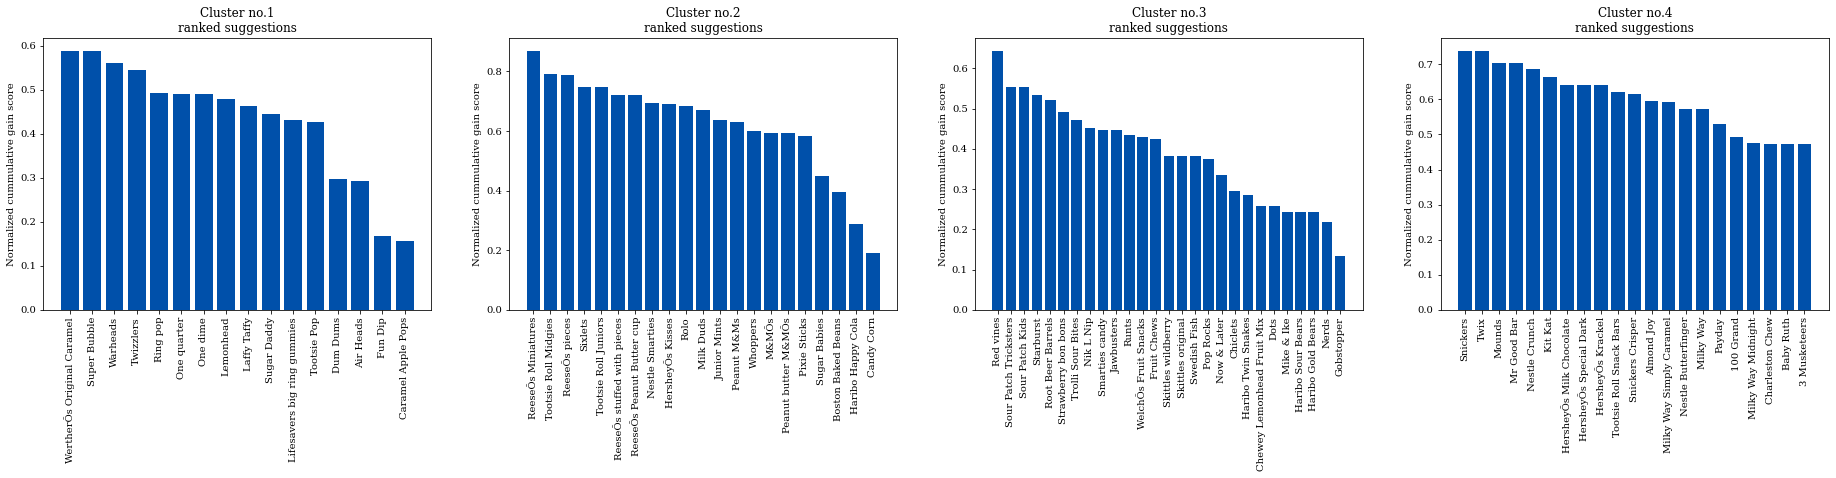

In [16]:
def predict(model, df):
    return model.predict(df.loc[:, ~df.columns.isin(["cluster_id"])])


X = df_ranking.loc[:, ~df_ranking.columns.isin(['relevance'])]
Y = df_ranking.loc[:, df_ranking.columns.isin(['relevance'])]
predictions = X.groupby("cluster_id").apply(lambda x: list(zip(predict(model, x), x['competitorname'])))


ordered = []
for cluster in predictions:
    ord =sorted(cluster, key=lambda x: x[0], reverse=True)    
    ordered.append([(val, preprocessor.dec[id]) for (val,id) in ord])


def plot_ranked_suggestion(idx, ordered_data,ax):
    # save the names and their respective scores separately
    # reverse the tuples to go from most frequent to least frequent 
    candy = list(zip(*ordered_data))[1]
    score = list(zip(*ordered_data))[0]

    x_pos = np.arange(len(candy)) 
    ax.set_title(f"Cluster no.{idx+1}\nranked suggestions")
    ax.set_xticklabels(ax.get_xticks(), rotation = 90)
   
    ax.bar(x_pos, score, align='center', color='#0050aa')
    ax.set_xticks(x_pos, candy) 
    ax.set_ylabel('Normalized cummulative gain score')



fig,axs = plt.subplots(1, len(ordered), figsize=(8*len(ordered), 5))

[plot_ranked_suggestion(idx, o,ax) for idx,(o,ax) in enumerate(zip(ordered,axs))]
plt.savefig("figs/suggested-ranked-items.png", dpi=400, bbox_inches="tight")


### Propose the top 1-2 candies from each cluster